In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


* Part 1

In [2]:
# Set random seed
np.random.seed(42)

# Feature matrix A
A = np.array([
    [1, 2.0],
    [1, 3.0],
    [1, 4.5],
    [1, 5.5]
])

# Target vector y
y = np.array([
    [3.1],
    [4.9],
    [8.2],
    [10.1]
])

m = len(y)


In [3]:
# Method 1: Normal Equations
AT_A = A.T @ A
AT_y = A.T @ y

theta_normal = np.linalg.inv(AT_A) @ AT_y

print("Normal Equations θ:")
print(theta_normal)


Normal Equations θ:
[[-1.04137931]
 [ 2.03103448]]


In [4]:
# Method 2: Batch Gradient Descent (BGD)
learning_rate = 0.01
n_iterations = 1000

# Initialize theta with zeros
theta_bgd = np.zeros((2, 1))

# Gradient descent loop
for i in range(n_iterations):
    grad = (1/m) * (A.T @ (A @ theta_bgd - y))
    theta_bgd = theta_bgd - learning_rate * grad

print("BGD θ after 1000 iterations:")
print(theta_bgd)

# Cost function
def cost(A, y, theta):
    m = len(y)
    return (1/(2*m)) * np.linalg.norm(A @ theta - y)**2

print("J(theta_normal) =", cost(A, y, theta_normal))
print("J(theta_bgd)    =", cost(A, y, theta_bgd))

BGD θ after 1000 iterations:
[[-0.55217831]
 [ 1.9146829 ]]
J(theta_normal) = 0.005064655172413768
J(theta_bgd)    = 0.01873147001124011


In [5]:
# Method 3: SVD + Pseudoinverse
U, S, VT = np.linalg.svd(A, full_matrices=False)
S_inv = np.diag(1 / S)
A_pinv = VT.T @ S_inv @ U.T

theta_svd = A_pinv @ y

print("SVD θ:")
print(theta_svd)

print("J(theta_svd) =", cost(A, y, theta_svd))

SVD θ:
[[-1.04137931]
 [ 2.03103448]]
J(theta_svd) = 0.00506465517241375


In [6]:
# Part 4: Numerical Stability Test (Collinearity)

# Build a new matrix with heavy collinearity
noise = np.random.rand(m, 1) * 0.0001
A_collinear = np.hstack((A, A[:, [1]] + noise))

print("A_collinear:")
print(A_collinear)

# Solve again with Normal Equations
AT_A_col = A_collinear.T @ A_collinear
AT_y_col = A_collinear.T @ y

theta_normal_col = np.linalg.inv(AT_A_col) @ AT_y_col

# Solve again using SVD pseudoinverse
U_c, S_c, VT_c = np.linalg.svd(A_collinear, full_matrices=False)
S_c_inv = np.diag(1 / S_c)
A_pinv_c = VT_c.T @ S_c_inv @ U_c.T

theta_svd_col = A_pinv_c @ y

print("Normal Eq θ (collinear):")
print(theta_normal_col)

print("SVD θ (collinear):")
print(theta_svd_col)

# Condition number of ATA (measures ill-conditioning)
cond_AT_A_col = np.linalg.cond(AT_A_col)
print("cond(A_collinear^T A_collinear) =", cond_AT_A_col)

# Cost comparison
print("J(theta_normal_col) =", cost(A_collinear, y, theta_normal_col))
print("J(theta_svd_col)    =", cost(A_collinear, y, theta_svd_col))


A_collinear:
[[1.         2.         2.00003745]
 [1.         3.         3.00009507]
 [1.         4.5        4.5000732 ]
 [1.         5.5        5.50005987]]
Normal Eq θ (collinear):
[[-8.53802729e-01]
 [ 3.43828068e+03]
 [-3.43623882e+03]]
SVD θ (collinear):
[[-8.53775599e-01]
 [ 3.43826298e+03]
 [-3.43622113e+03]]
cond(A_collinear^T A_collinear) = 155701464464.4163
J(theta_normal_col) = 0.0025894233049297945
J(theta_svd_col)    = 0.002589423257457117


* Part 2

In [7]:
# Step 1: Load and clean data

# Load Auto MPG dataset from local file
data_path = "auto-mpg.data"

column_names = [
    "MPG", "Cylinders", "Displacement", "Horsepower",
    "Weight", "Acceleration", "ModelYear", "Origin", "CarName"
]

data_mpg = pd.read_csv(
    data_path,
    names=column_names,
    na_values="?",
    delim_whitespace=True
)

# Drop rows with missing Horsepower
data_mpg = data_mpg.dropna(subset=["Horsepower"])

# Convert Horsepower to float
data_mpg["Horsepower"] = data_mpg["Horsepower"].astype(float)


/tmp/ipykernel_5983/1262795514.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data_mpg = pd.read_csv(


In [8]:
# Step 2: Build A and y
# Model: MPG = theta0 + theta1 * Horsepower

# Extract y (MPG) as column vector
y = data_mpg["MPG"].values.reshape(-1, 1)

# Extract feature (Horsepower) as column vector
hp = data_mpg["Horsepower"].values.reshape(-1, 1)

# Normalize feature (important for gradient descent)
hp_mean = hp.mean()
hp_std = hp.std()
hp_norm = (hp - hp_mean) / hp_std

# Build design matrix A with bias term
# A = [1, hp_norm]
A = np.hstack([np.ones_like(hp_norm), hp_norm])

m, n = A.shape  # number of samples and features



In [9]:
# Helper: Cost function
# J(theta) = 1/(2m) * ||A theta - y||^2
def cost(A, y, theta):
    m = len(y)
    return (1 / (2 * m)) * np.linalg.norm(A @ theta - y) ** 2

# Step 3.2: Implement SGD

def sgd(A, y, learning_rate=0.01, n_iterations=5000):
    m, n = A.shape
    theta = np.zeros((n, 1))
    J_history = []

    for t in range(n_iterations):
        # Pick one random sample
        i = np.random.randint(m)
        Ai = A[i:i+1, :]      # shape (1, n)
        yi = y[i:i+1, :]      # shape (1, 1)

        # Stochastic gradient for this sample
        grad_i = Ai.T @ (Ai @ theta - yi)  # shape (n, 1)

        # Update theta
        theta = theta - learning_rate * grad_i

        # Compute full cost over all data and store it
        J_history.append(cost(A, y, theta))

    return theta, J_history


In [10]:
# Step 3.2: Implement BGD

def bgd(A, y, learning_rate=0.01, n_iterations=1000):
    m, n = A.shape
    theta = np.zeros((n, 1))
    J_history = []

    for t in range(n_iterations):
        # Full batch gradient (uses all samples)
        grad = (1 / m) * (A.T @ (A @ theta - y))

        # Update theta
        theta = theta - learning_rate * grad

        # Compute full cost over all data and store it
        J_history.append(cost(A, y, theta))

    return theta, J_history

# Run SGD and BGD
np.random.seed(42)  # for reproducibility

theta_sgd, J_sgd = sgd(A, y, learning_rate=0.01, n_iterations=5000)
theta_bgd, J_bgd = bgd(A, y, learning_rate=0.01, n_iterations=1000)

print("SGD theta:")
print(theta_sgd)

print("BGD theta:")
print(theta_bgd)

print("Final cost (SGD):", J_sgd[-1])
print("Final cost (BGD):", J_bgd[-1])



SGD theta:
[[22.78982222]
 [-6.59270376]]
BGD theta:
[[23.44490618]
 [-6.06761045]]
Final cost (SGD): 12.324786524945141
Final cost (BGD): 11.971832015876284


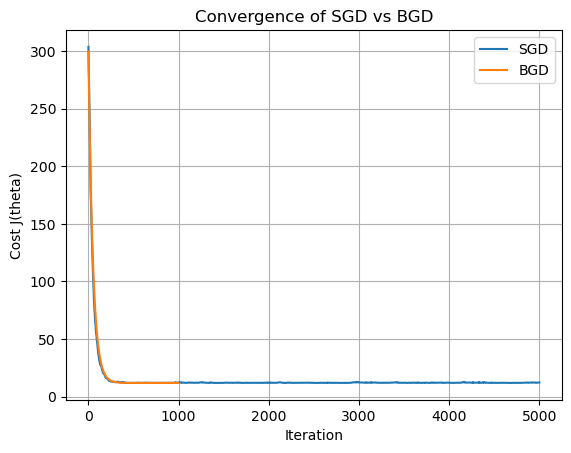

Figure saved to: outputs/sgd_vs_bgd_convergence.png


In [11]:
# Step 4: Plot convergence curves

output_dir = "outputs"
plt.figure()
plt.plot(range(len(J_sgd)), J_sgd, label="SGD")
plt.plot(range(len(J_bgd)), J_bgd, label="BGD")
plt.xlabel("Iteration")
plt.ylabel("Cost J(theta)")
plt.title("Convergence of SGD vs BGD")
plt.legend()
plt.grid(True)

# Save figure inside CMD3/outputs
save_path = os.path.join(output_dir, "sgd_vs_bgd_convergence.png")
plt.savefig(save_path, dpi=300)

plt.show()

print(f"Figure saved to: {save_path}")

* Part 3

In [12]:
# PART 3 — Nonlinear Regression (Degree 2)

# Define x from part 2 (Horsepower)
x = hp   # hp was defined in part 2

# Build polynomial features: x and x^2
X_poly = np.hstack([x, x**2])

# Normalize columns of polynomial features
X_mean = X_poly.mean(axis=0, keepdims=True)
X_std = X_poly.std(axis=0, keepdims=True)
X_poly_norm = (X_poly - X_mean) / X_std

# Build design matrix Apoly = [1, x_norm, x2_norm]
m = X_poly_norm.shape[0]
ones = np.ones((m, 1))
Apoly = np.hstack([ones, X_poly_norm])


# Cost function
def cost(A, y, theta):
    m = len(y)
    return (1/(2*m)) * np.linalg.norm(A@theta - y)**2


# SGD implementation for polynomial regression
def sgd(A, y, learning_rate=0.01, n_iterations=5000):
    m, n = A.shape
    theta = np.zeros((n, 1))
    J_history = []

    for t in range(n_iterations):
        i = np.random.randint(m)
        Ai = A[i:i+1, :]
        yi = y[i:i+1, :]

        grad_i = Ai.T @ (Ai@theta - yi)
        theta = theta - learning_rate * grad_i

        J_history.append(cost(A, y, theta))

    return theta, J_history


# Train polynomial model
np.random.seed(42)
theta_poly, J_poly = sgd(Apoly, y, learning_rate=0.01, n_iterations=5000)

print("Polynomial Regression θ (degree 2):")
print(theta_poly)
print("Final cost:", J_poly[-1])


Polynomial Regression θ (degree 2):
[[ 22.85549896]
 [-11.8877907 ]
 [  5.54816999]]
Final cost: 10.457035886487292


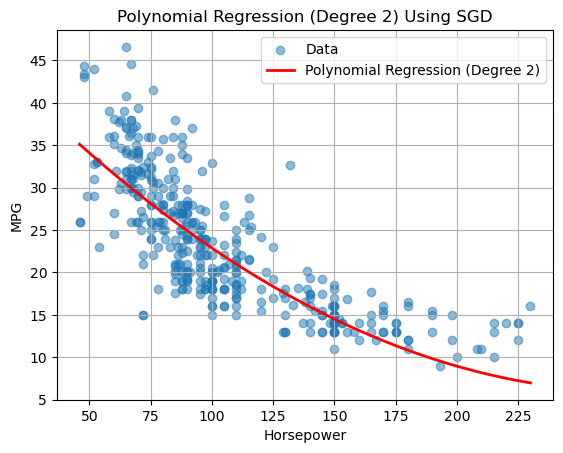

Figure saved to: outputs/poly_regression_curve.png


In [13]:
# Plot nonlinear regression curve

output_dir = "outputs"
plt.figure()
plt.scatter(x, y, alpha=0.5, label="Data")

# Smooth x-range for curve
x_grid = np.linspace(x.min(), x.max(), 200).reshape(-1, 1)
X_poly_grid = np.hstack([x_grid, x_grid**2])

# Normalize grid using training mean/std
X_poly_grid_norm = (X_poly_grid - X_mean) / X_std

# Build grid design matrix
Apoly_grid = np.hstack([np.ones((x_grid.shape[0], 1)), X_poly_grid_norm])

# Predict MPG on smooth curve
y_pred_grid = Apoly_grid @ theta_poly

plt.plot(x_grid, y_pred_grid, color='red', linewidth=2,
         label="Polynomial Regression (Degree 2)")

plt.xlabel("Horsepower")
plt.ylabel("MPG")
plt.title("Polynomial Regression (Degree 2) Using SGD")
plt.legend()
plt.grid(True)

# Save figure inside outputs folder
save_path = os.path.join(output_dir, "poly_regression_curve.png")
plt.savefig(save_path, dpi=300)

plt.show()

print(f"Figure saved to: {save_path}")